In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import signatory
import base
import neural_inverse
from importlib import reload
reload(neural_inverse)

<module 'neural_inverse' from '../src\\neural_inverse.py'>

## Learn the inverse of log-signature (pytorch)

In [2]:
N = 20
batch = 1000
split = int(batch/2)
path = neural_inverse.generate_bmpath(batch, N)
path_torch = neural_inverse.leadlag(torch.tensor(path)[:,:,0])
path_leadlag = path_torch.numpy()
order = 5
logsig = signatory.logsignature(path_torch, order)

In [3]:
X = logsig.numpy()
y = path_leadlag
ds, dl, X_train, y_train, X_test, y_test = neural_inverse.data_prepare(X,y)
net = neural_inverse.Net(X.shape[-1],order,N)
net.train_net(dl,1000)

step:  0 loss:  1.630290050059557
step:  100 loss:  0.0034210581507068127
step:  200 loss:  0.0030951335502322763
step:  300 loss:  0.006444153666961938
step:  400 loss:  0.0032975779031403363
step:  500 loss:  0.0027955900732195005
step:  600 loss:  0.0020904791163047776
step:  700 loss:  0.0018500416772440076
step:  800 loss:  0.0024751575401751325
step:  900 loss:  0.003106992196990177
Finished Training


in sample compare
LOSS is:  0.00040235036


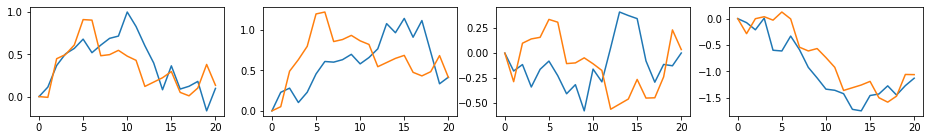

out sample compare
LOSS is:  0.00083941955


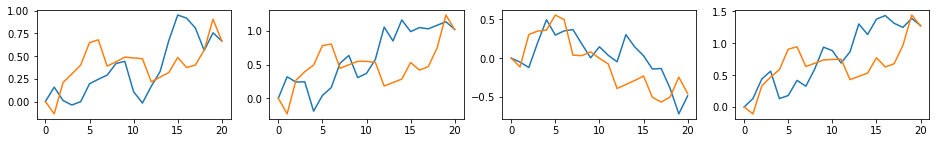

In [4]:
reload(neural_inverse)

print('in sample compare')
neural_inverse.reconstruct_plot(net, X_train,y_train)

print('out sample compare')
neural_inverse.reconstruct_plot(net, X_test, y_test)

## Reverse a single path

In [5]:
T = 1
N = 20
dt = T/N
batch = 1
pathBM = neural_inverse.generate_bmpath(batch, N)
time = np.linspace(0,1,N+1)

sigma = 1
path0 = np.exp(sigma * pathBM - 0.5*sigma**2*time[None,:,None])

path_torch = neural_inverse.leadlag(torch.tensor(path0)[:,:,0])
path_leadlag = path_torch.numpy()
order = 5
logsig = signatory.logsignature(path_torch, order)

X0 = logsig.numpy()
y0 = path_leadlag
dl = neural_inverse.data_prepare(X0,y0)
net0 = neural_inverse.Net(X0.shape[-1],order,N)
net0.train_net(dl,1000)
y_recover, logsig_recover = neural_inverse.reconstruct_plot(net0, X0, y0, order)

step:  0 loss:  0.4257391393184662
step:  100 loss:  0.0050721908919513226
step:  200 loss:  2.2534781237482093e-05
step:  300 loss:  5.69978737985366e-06
step:  400 loss:  2.8949409625056433e-06
step:  500 loss:  2.129617541868356e-06
step:  600 loss:  1.6911408238229342e-06
step:  700 loss:  3.2691027627151925e-06
step:  800 loss:  1.2799099522453616e-06
step:  900 loss:  1.5853794366194052e-06
Finished Training
LOSS is:  1.0520434e-06


## Compare with evolution algorithm

In [6]:
import base
import logsig_inversion
pip = 0.01
n_pips = 10
n_points = N+1
order = 5
n_iterations = 100
n_organisms = 1000
recovered_path, loss = logsig_inversion.train(X0[0], order, n_iterations, n_organisms, n_points, pip, n_pips)
recovered_path = recovered_path + path0[0,0,0]

In [7]:
logsig_recover2 = signatory.logsignature(neural_inverse.leadlag(torch.tensor(recovered_path)[None,:]), order)
XX = torch.tensor(X0, dtype = torch.float)
print('True log signature: \n', XX[0])
print('Neural log signature: \n', logsig_recover[0])
print('Evolution log signature: \n', logsig_recover2[0])

True log signature: 
 tensor([-0.5480, -0.5480, -0.3223, -0.1158,  0.1085, -0.0238,  0.0454, -0.0248,
        -0.0035,  0.0100, -0.0277, -0.0110,  0.0242,  0.0044])
Neural log signature: 
 tensor([-0.5479, -0.5479, -0.3223, -0.1168,  0.1078, -0.0248,  0.0469, -0.0248,
        -0.0036,  0.0099, -0.0250, -0.0099,  0.0244,  0.0036])
Evolution log signature: 
 tensor([-0.5500, -0.5500, -0.0856, -0.0355,  0.0344, -0.0106,  0.0211, -0.0105,
        -0.0022,  0.0065, -0.0151, -0.0065,  0.0153,  0.0022],
       dtype=torch.float64)


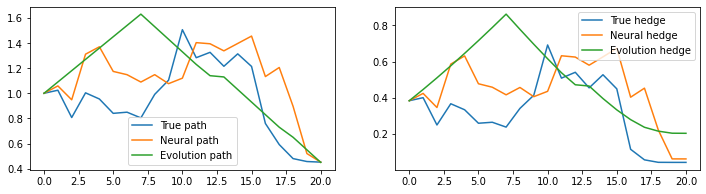

In [8]:
import hedge
reload(hedge)
K = 1
sigma = 1
C, V = hedge.delta_hedge(K, sigma, time, path0[0,:,0])
C_recover, V_recover = hedge.delta_hedge(K, sigma, time, y_recover.numpy())
C_recover2, V_recover2 = hedge.delta_hedge(K, sigma, time, recovered_path)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(path0[0])
plt.plot(y_recover)
plt.plot(recovered_path)
plt.legend(['True path', 'Neural path', 'Evolution path'])
plt.subplot(1, 2, 2)
plt.plot(V)
plt.plot(V_recover)
plt.plot(V_recover2)
plt.legend(['True hedge', 'Neural hedge', 'Evolution hedge'])
plt.show()